In [170]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


In [171]:
import matplotlib.pyplot as plt
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
# !pip install pmdarima
from pmdarima.arima import auto_arima
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM , Dense

In [172]:
df = pd.read_csv("DataChar.csv")

In [173]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 503 entries, 0 to 502
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    503 non-null    object 
 1   Value   503 non-null    float64
dtypes: float64(1), object(1)
memory usage: 8.0+ KB


In [174]:
df.head()

,Date,Value
0,1980-01-01,0.061364
1,1980-02-01,-0.060004
2,1980-03-01,-0.074088
3,1980-04-01,0.152491
4,1980-05-01,0.203524


In [175]:
df.tail()

,Date,Value
498,2021-07-01,0.998214
499,2021-08-01,1.164914
500,2021-09-01,0.845665
501,2021-10-01,0.716998
502,2021-11-01,0.528394


In [176]:
df['Date'] = pd.to_datetime(df['Date'])
df.set_index("Date" , inplace = True)

In [177]:
df.head()

,Value
Date,
1980-01-01,0.061364
1980-02-01,-0.060004
1980-03-01,-0.074088
1980-04-01,0.152491
1980-05-01,0.203524


In [178]:
# Make the data have equal spacing steps
df = df["Value"].resample("1D").mean().fillna(method = "ffill").to_frame()
dates = df.index

In [179]:
cut_off = int(len(df) * 0.8)
df.iloc[cut_off]

Value    1.675195
Name: 2013-06-20 00:00:00, dtype: float64

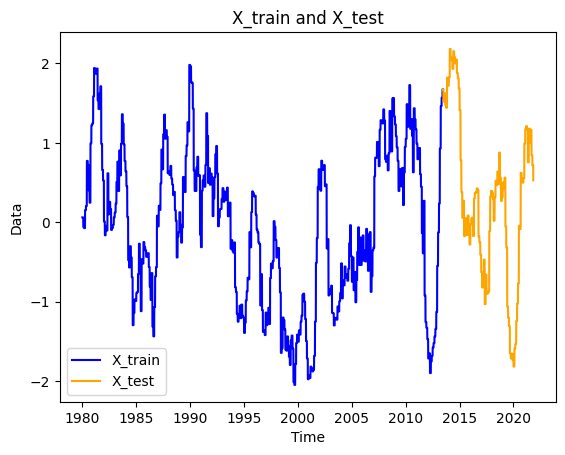

In [180]:
plt.plot(df.index[:cut_off] , df.iloc[:cut_off]["Value"] , color='blue', label='X_train')
plt.plot(df.index[cut_off:] , df.iloc[cut_off:]["Value"] , color='orange', label='X_test')
plt.xlabel('Time')
plt.ylabel('Data')
plt.title('X_train and X_test')
plt.legend()
plt.show()

In [181]:
def Create_Features(df):
    """
        Create some features from the date of the data
    """
    df['Year'] = df.index.year
    df['Month'] = df.index.month
    df['Day'] = df.index.day
    df['DayOfWeek'] = df.index.dayofweek
    df['DayOfYear'] = df.index.dayofyear
    df['Hour'] = df.index.hour
    df['Minute'] = df.index.minute
    df['Second'] = df.index.second
    df['Quarter'] = df.index.quarter
    df['IsLeapYear'] = df.index.is_leap_year
    df['IsLeapYear'] = df["IsLeapYear"].astype(int)
    return df

In [182]:
df = Create_Features(df)

In [183]:
df.head()

,Value,Year,Month,Day,DayOfWeek,DayOfYear,Hour,Minute,Second,Quarter,IsLeapYear
Date,,,,,,,,,,,
1980-01-01,0.061364,1980,1,1,1,1,0,0,0,1,1
1980-01-02,0.061364,1980,1,2,2,2,0,0,0,1,1
1980-01-03,0.061364,1980,1,3,3,3,0,0,0,1,1
1980-01-04,0.061364,1980,1,4,4,4,0,0,0,1,1
1980-01-05,0.061364,1980,1,5,5,5,0,0,0,1,1


In [184]:
# Use MinMaxScaler to scale the data between 0 , 1 "Achieve better results only on LSTM"
scaler = MinMaxScaler()
df["Value"] = scaler.fit_transform(df["Value"].values.reshape(-1, 1))
df = pd.DataFrame(df)
df.head()

,Value,Year,Month,Day,DayOfWeek,DayOfYear,Hour,Minute,Second,Quarter,IsLeapYear
Date,,,,,,,,,,,
1980-01-01,0.498642,1980,1,1,1,1,0,0,0,1,1
1980-01-02,0.498642,1980,1,2,2,2,0,0,0,1,1
1980-01-03,0.498642,1980,1,3,3,3,0,0,0,1,1
1980-01-04,0.498642,1980,1,4,4,4,0,0,0,1,1
1980-01-05,0.498642,1980,1,5,5,5,0,0,0,1,1


In [185]:
Features = ["Year" , "Month" , "DayOfYear" , "Hour" , 
            "Minute" , "Second" , "Quarter" , "IsLeapYear"]
Target = ["Value"]
X = df[Features]
Y = df[Target]
X_train = X.iloc[:cut_off]
Y_train = Y.iloc[:cut_off]
X_test = X.iloc[cut_off:]
Y_test = Y.iloc[cut_off:]
print(len(X_train))
print(len(Y_train))
print(len(X_test))
print(len(Y_test))

12224
12224
3057
3057


In [186]:
X_train.head()

,Year,Month,DayOfYear,Hour,Minute,Second,Quarter,IsLeapYear
Date,,,,,,,,
1980-01-01,1980,1,1,0,0,0,1,1
1980-01-02,1980,1,2,0,0,0,1,1
1980-01-03,1980,1,3,0,0,0,1,1
1980-01-04,1980,1,4,0,0,0,1,1
1980-01-05,1980,1,5,0,0,0,1,1


In [187]:
Y_train.head()

,Value
Date,
1980-01-01,0.498642
1980-01-02,0.498642
1980-01-03,0.498642
1980-01-04,0.498642
1980-01-05,0.498642


# **Linear Regression**

In [188]:
lr = make_pipeline(StandardScaler(), LinearRegression())
lr.fit(X_train , Y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('linearregression', LinearRegression())])

In [189]:
Y_test

,Value
Date,
2013-06-20,0.879919
2013-06-21,0.879919
2013-06-22,0.879919
2013-06-23,0.879919
2013-06-24,0.879919
...,...
2021-10-28,0.653539
2021-10-29,0.653539
2021-10-30,0.653539


In [190]:
Y_pred_lr = lr.predict(X_test)
# Inverse the MinMaxScaler transformation to calculate comparable MSE between models & 
# To predict real values of gold prices
Y_pred_lr = scaler.inverse_transform(Y_pred_lr.reshape(-1, 1))
Y_test_lr = scaler.inverse_transform(Y_test.values.reshape(-1, 1))

In [191]:
mean_squared_error(Y_test_lr , Y_pred_lr)

1.4691709724355497

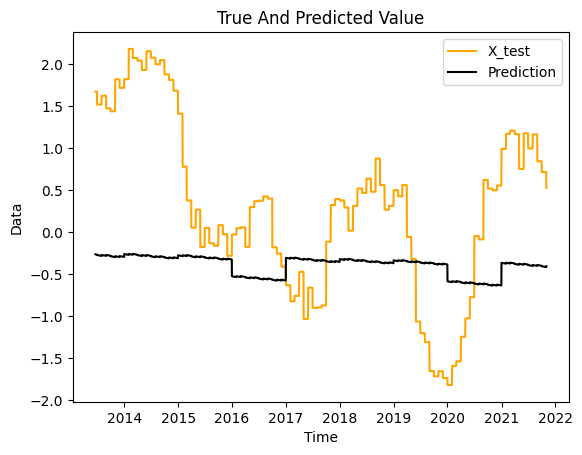

In [192]:
#plt.plot(df.iloc[:cut_off]["Date"] , df.iloc[:cut_off]["Value"] , color='blue', label='X_train')
plt.plot(df.index[cut_off:] , Y_test_lr , color='orange', label='X_test')
plt.plot(df.index[cut_off:] , Y_pred_lr , color='Black', label='Prediction')
plt.xlabel('Time')
plt.ylabel('Data')
plt.title('True And Predicted Value')
plt.legend()
plt.show()

# **XGBoost Regressor**

In [193]:
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBRegressor
from scipy.stats import uniform

# Định nghĩa mô hình cơ bản
xgb = XGBRegressor(random_state=42)

# Tập hợp các tham số cần thử nghiệm
param_distributions = {
    'n_estimators': [50, 100, 200],
    'learning_rate': uniform(0.01, 0.1),  # Dải giá trị cho learning_rate
    'max_depth': [3, 4, 5],
    'min_child_weight': [1, 3, 5],
    'subsample': uniform(0.8, 0.2),      # Dải giá trị cho subsample
    'colsample_bytree': uniform(0.8, 0.2)
}

# Khởi tạo RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_distributions,
    scoring='neg_mean_squared_error',
    n_iter=50,                      # Số lượng tổ hợp thử nghiệm
    cv=5,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

# Chạy tìm kiếm
random_search.fit(X_train, Y_train)

# In kết quả tốt nhất
print("Best parameters found: ", random_search.best_params_)
print("Best score found: ", -random_search.best_score_)


Fitting 5 folds for each of 50 candidates, totalling 250 fits


Best parameters found:  {'colsample_bytree': 0.821578285398661, 'learning_rate': 0.013142918568673426, 'max_depth': 5, 'min_child_weight': 1, 'n_estimators': 50, 'subsample': 0.9017141382329406}
Best score found:  0.051915731980043664


In [194]:
xgb = XGBRegressor(colsample_bytree= 0.821578285398661, learning_rate= 0.013142918568673426, max_depth= 5, min_child_weight= 1, n_estimators= 50, subsample= 0.9017141382329406 )
xgb.fit(X_train , Y_train ,verbose = 50)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.821578285398661, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.013142918568673426,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             n_estimators=50, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [195]:
Y_pred_xgb = xgb.predict(X_test)
Y_pred_xgb = scaler.inverse_transform(Y_pred_xgb.reshape(-1, 1))
Y_test_xgb = scaler.inverse_transform(Y_test)

In [196]:
mean_squared_error(Y_test_xgb , Y_pred_xgb)

1.0506289040910692

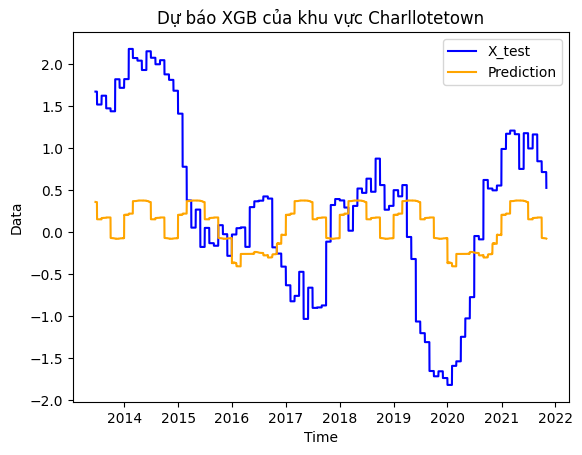

In [197]:
#plt.plot(df.iloc[:cut_off]["Date"] , df.iloc[:cut_off]["Value"] , color='blue', label='X_train')
plt.plot(df.index[cut_off:] , Y_test_xgb , color='blue', label='X_test')
plt.plot(df.index[cut_off:] , Y_pred_xgb , color='orange', label='Prediction')
plt.xlabel('Time')
plt.ylabel('Data')
plt.title('Dự báo XGB của khu vực Charllotetown')
plt.legend()
plt.show()

In [198]:
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error
from xgboost import XGBRegressor

# Hàm MAPE
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Hàm RMSE
def root_mean_squared_error(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

# Hàm dự báo m bước
def forecast_m_steps(model, X_test, m_steps):
    if len(X_test) == 0:
        raise ValueError("X_test is empty. Please provide valid input data.")
    if not isinstance(X_test, np.ndarray):
        X_test = np.array(X_test)

    forecasts = []
    current_input = X_test[-1]  # Sử dụng điểm cuối cùng làm đầu vào ban đầu
    for _ in range(m_steps):
        prediction = model.predict(current_input.reshape(1, -1))[0]  # Dự báo một bước
        forecasts.append(prediction)  # Lưu dự báo
        # Cập nhật đầu vào: Loại bỏ điểm đầu tiên và thêm dự báo
        current_input = np.roll(current_input, -1)  # Trượt sang trái
        current_input[-1] = prediction  # Thêm dự báo mới vào cuối
    return forecasts

# Huấn luyện mô hình XGBoost
XGB_model = XGBRegressor()
XGB_model.fit(X_train, Y_train)

# Dự đoán trên tập kiểm tra
Y_pred_xgb = XGB_model.predict(X_test)

# Tính toán các chỉ số đánh giá
mse = mean_squared_error(Y_test, Y_pred_xgb)
rmse = root_mean_squared_error(Y_test, Y_pred_xgb)
mae = mean_absolute_error(Y_test, Y_pred_xgb)
mape = mean_absolute_percentage_error(Y_test, Y_pred_xgb)

print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)
print("Mean Absolute Error (MAE):", mae)
print("Mean Absolute Percentage Error (MAPE):", mape)

# Gọi hàm dự báo m bước
m_steps = 12  # Số bước dự báo
Y_forecast_xgb = forecast_m_steps(model=XGB_model, X_test=X_test, m_steps=m_steps)
print(f"Dự báo {m_steps} bước tiếp theo:", Y_forecast_xgb)


Mean Squared Error (MSE): 0.08617816574907232
Root Mean Squared Error (RMSE): 0.2935611788862286
Mean Absolute Error (MAE): 0.2461429615945292
Mean Absolute Percentage Error (MAPE): 83.42992782918999
Dự báo 12 bước tiếp theo: [0.36419794, 0.7720048, 0.49952823, 0.49952823, 0.49952823, 0.524973, 0.49952823, 0.49952823, 0.49952823, 0.49952823, 0.49952823, 0.49952823]


In [199]:
feat_imp = pd.DataFrame(index = xgb.feature_names_in_ ,
                        data = xgb.feature_importances_ , 
                        columns = ["importance"])

In [200]:
feat_imp

,importance
Year,0.544022
Month,0.050741
DayOfYear,0.010091
Hour,0.000000
Minute,0.000000
Second,0.000000
Quarter,0.059687
IsLeapYear,0.335459


<Axes: title={'center': 'Feature Importances'}>

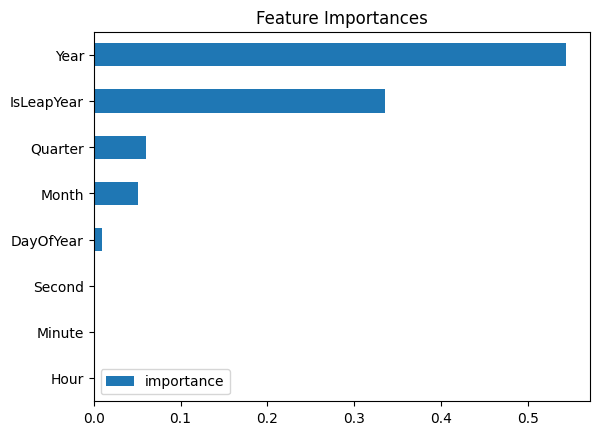

In [201]:
feat_imp.sort_values('importance').plot(kind = "barh" , title = "Feature Importances")

# **Using ARIMA model**

In [202]:
arima = auto_arima(Y_train , stepwise = False , seasonal = False , exogenous=X_train)

In [203]:
arima

ARIMA(order=(0, 1, 0), scoring_args={}, suppress_warnings=True)

In [204]:
arima.summary()
#arima.fit(Y_train)

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                12224
Model:               SARIMAX(0, 1, 0)   Log Likelihood               35681.322
Date:                Mon, 13 Jan 2025   AIC                         -71358.644
Time:                        11:18:10   BIC                         -71343.822
Sample:                    01-01-1980   HQIC                        -71353.676
                         - 06-19-2013                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   3.119e-05      0.000      0.264      0.792      -0.000       0.000
sigma2         0.0002   2.91e-07    586.252      0.000       0.000       0.000
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):           6221585.68
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.09   Skew:                            -0.23
Prob(H) (two-sided):                  0.00   Kurtosis:                       113.53
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [205]:
Y_pred_arima = arima.predict(n_periods = len(X_test))
Y_pred_arima = scaler.inverse_transform(Y_pred_arima.values.reshape(-1, 1))
Y_test_arima = scaler.inverse_transform(Y_test)
mean_squared_error(Y_test_arima , Y_pred_arima)

3.6476242574090674

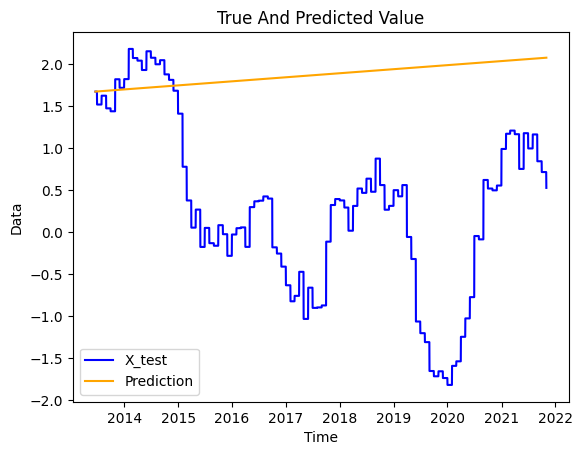

In [206]:
#plt.plot(df.iloc[:cut_off]["Date"] , df.iloc[:cut_off]["Value"] , color='blue', label='X_train')
plt.plot(df.index[cut_off:] , Y_test_arima , color='blue', label='X_test')
plt.plot(df.index[cut_off:] , Y_pred_arima , color='orange', label='Prediction')
plt.xlabel('Time')
plt.ylabel('Data')
plt.title('True And Predicted Value')
plt.legend()
plt.show()

In [207]:
Y_test_arima.shape , Y_pred_arima.shape

((3057, 1), (3057, 1))

In [208]:
# The difference between true and predicted values in ARIMA
res_arima = pd.DataFrame({"True": Y_test_arima.flatten() , 
                          "Predicted": Y_pred_arima.flatten()})
res_arima

,True,Predicted
0,1.675195,1.675327
1,1.675195,1.675459
2,1.675195,1.675591
3,1.675195,1.675723
4,1.675195,1.675855
...,...,...
3052,0.716998,2.078241
3053,0.716998,2.078373
3054,0.716998,2.078505
3055,0.716998,2.078637


# **Using LSTM**

In [209]:
df_lstm = pd.read_csv("kaggle/input/DataChar.csv")

FileNotFoundError: [Errno 2] No such file or directory: 'kaggle/input/DataChar.csv'

In [39]:
df_lstm.index = pd.to_datetime(df_lstm['Date'])
df_lstm = df_lstm["Value"].resample("1D").mean().fillna(method = "ffill").to_frame()

In [40]:
df_lstm = scaler.fit_transform(df_lstm)
df_lstm = pd.DataFrame(df_lstm)
df_lstm.columns = ["Value"]
df_lstm.index = dates
df_lstm.head()

,Value
Date,
1980-01-01,0.498642
1980-01-02,0.498642
1980-01-03,0.498642
1980-01-04,0.498642
1980-01-05,0.498642


In [41]:
def df_to_XY(df_lstm , window_size):
    """
        Converting the dataframe into Xs and Ys. Take every window size step and put 
        it into Xs and Ys.
    """
    df_as_np = df_lstm.to_numpy()
    X = []
    Y = []
    for i in range(len(df_as_np) - window_size):
        row = [[a] for a in df_as_np[i : i + window_size]]
        X.append(row)
        label = df_as_np[i+window_size]
        Y.append(label)
    return np.array(X) , np.array(Y)

In [42]:
window_size = 30
X_lstm , Y_lstm = df_to_XY(df_lstm , window_size = window_size)
X_lstm = np.reshape(X_lstm, (X_lstm.shape[0] , X_lstm.shape[1] , 1))
X_lstm.shape , Y_lstm.shape

((15251, 30, 1), (15251, 1))

In [43]:
train_size = int(X_lstm.shape[0] * 0.6)
val_size   = int(X_lstm.shape[0] * 0.2)
test_size  = int(X_lstm.shape[0] * 0.2)

In [44]:
# Slicing data as this time we need train , validation and test sets
X_train , Y_train = X_lstm[0 : train_size] , Y_lstm[0 : train_size]
X_val   , Y_val   = X_lstm[train_size : train_size + val_size] , Y_lstm[train_size : train_size + val_size]
X_test , Y_test   = X_lstm[train_size + val_size : train_size + val_size + test_size] , Y_lstm[train_size + val_size : train_size + val_size + test_size]
X_train.shape , Y_train.shape , X_val.shape , Y_val.shape ,X_test.shape , Y_test.shape 

((9150, 30, 1), (9150, 1), (3050, 30, 1), (3050, 1), (3050, 30, 1), (3050, 1))

In [45]:
model = Sequential()
model.add(LSTM(50 , return_sequences = True , input_shape = (X_train.shape[1] , 1)))
model.add(LSTM(64, return_sequences= False))
model.add(Dense(32))
model.add(Dense(16))
model.add(Dense(1))
model.compile(optimizer= 'adam', loss= 'mse' , metrics= "mean_absolute_error")

2025-01-12 22:43:06.516410: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2025-01-12 22:43:06.516445: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2025-01-12 22:43:06.516470: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (codespaces-77ae63): /proc/driver/nvidia/version does not exist
2025-01-12 22:43:06.516676: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [46]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 30, 50)            10400     
                                                                 
 lstm_1 (LSTM)               (None, 64)                29440     
                                                                 
 dense (Dense)               (None, 32)                2080      
                                                                 
 dense_1 (Dense)             (None, 16)                528       
                                                                 
 dense_2 (Dense)             (None, 1)                 17        
                                                                 
Total params: 42,465
Trainable params: 42,465
Non-trainable params: 0
_________________________________________________________________


In [47]:
history = model.fit(X_train , Y_train , epochs = 50 ,  
                    validation_data = (X_val, Y_val) , batch_size = 32)

Epoch 1/50
286/286 [==============================] - 8s 20ms/step - loss: 0.0041 - mean_absolute_error: 0.0286 - val_loss: 0.0010 - val_mean_absolute_error: 0.0165
Epoch 2/50
286/286 [==============================] - 5s 18ms/step - loss: 6.3808e-04 - mean_absolute_error: 0.0130 - val_loss: 8.0108e-04 - val_mean_absolute_error: 0.0156
Epoch 3/50
286/286 [==============================] - 5s 18ms/step - loss: 5.0887e-04 - mean_absolute_error: 0.0115 - val_loss: 6.3432e-04 - val_mean_absolute_error: 0.0132
Epoch 4/50
286/286 [==============================] - 5s 18ms/step - loss: 4.5280e-04 - mean_absolute_error: 0.0114 - val_loss: 4.8349e-04 - val_mean_absolute_error: 0.0082
Epoch 5/50
286/286 [==============================] - 5s 19ms/step - loss: 3.6802e-04 - mean_absolute_error: 0.0093 - val_loss: 4.1553e-04 - val_mean_absolute_error: 0.0084
Epoch 6/50
286/286 [==============================] - 5s 19ms/step - loss: 3.2364e-04 - mean_absolute_error: 0.0095 - val_loss: 4.0839e-04 - va

In [48]:
df_lstm[train_size : train_size + val_size].index

DatetimeIndex(['2005-01-19', '2005-01-20', '2005-01-21', '2005-01-22',
               '2005-01-23', '2005-01-24', '2005-01-25', '2005-01-26',
               '2005-01-27', '2005-01-28',
               ...
               '2013-05-17', '2013-05-18', '2013-05-19', '2013-05-20',
               '2013-05-21', '2013-05-22', '2013-05-23', '2013-05-24',
               '2013-05-25', '2013-05-26'],
              dtype='datetime64[ns]', name='Date', length=3050, freq='D')

In [49]:
val_predictions = model.predict(X_val).flatten()
val_predictions = scaler.inverse_transform(val_predictions.reshape(-1, 1))
Y_val_lstm = scaler.inverse_transform(Y_val)
val_results = pd.DataFrame(index = df_lstm[train_size : train_size + val_size].index , data={'Val Predictions':val_predictions.flatten() , 'Actuals':Y_val_lstm.flatten()})
val_results

96/96 [==============================] - 1s 5ms/step


,Val Predictions,Actuals
Date,,
2005-01-19,-0.412107,-0.443865
2005-01-20,-0.412038,-0.443865
2005-01-21,-0.411964,-0.443865
2005-01-22,-0.411888,-0.443865
2005-01-23,-0.411813,-0.443865
...,...,...
2013-05-22,1.703387,1.675195
2013-05-23,1.703413,1.675195
2013-05-24,1.703438,1.675195


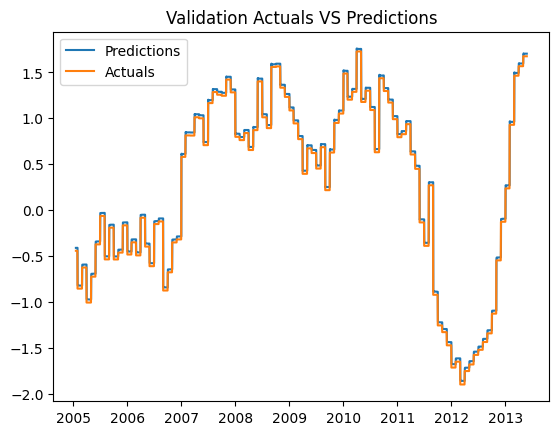

In [50]:
plt.plot(val_results['Val Predictions'])
plt.plot(val_results['Actuals'])
plt.legend(['Predictions', 'Actuals'])
plt.title("Validation Actuals VS Predictions")
plt.show()

In [51]:
Y_test_lstm = scaler.inverse_transform(Y_test)
test_predictions = model.predict(X_test)
test_predictions = scaler.inverse_transform(test_predictions)
test_results = pd.DataFrame(index = df_lstm[train_size + val_size : train_size + val_size + test_size].index , data={'Test Predictions':test_predictions.flatten() , 'Actuals':Y_test_lstm.flatten()})
test_results

96/96 [==============================] - 0s 5ms/step


,Test Predictions,Actuals
Date,,
2013-05-27,1.703503,1.675195
2013-05-28,1.703520,1.675195
2013-05-29,1.703534,1.675195
2013-05-30,1.703546,1.675195
2013-05-31,1.703557,1.675195
...,...,...
2021-09-27,0.750503,0.716998
2021-09-28,0.750485,0.716998
2021-09-29,0.750472,0.716998


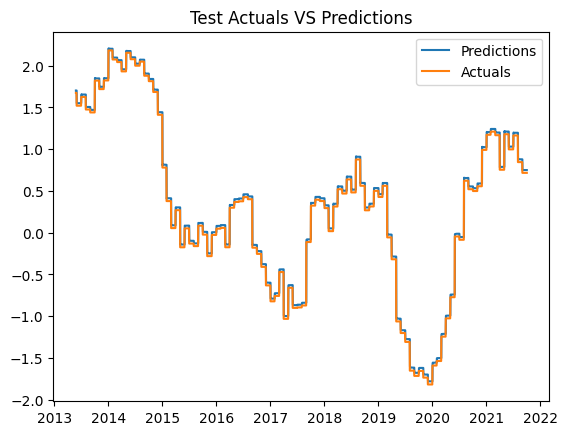

In [52]:
plt.plot(test_results['Test Predictions'])
plt.plot(test_results['Actuals'])
plt.legend(['Predictions', 'Actuals'])
plt.title("Test Actuals VS Predictions")
plt.show()

In [53]:
mean_squared_error(Y_test_lstm , test_predictions)

0.0035988179401603548

# **DataFrame of each model's predictions along with the actuals "Test" set**

In [54]:
Y_test_lstm.shape , test_predictions.shape , Y_pred_arima.shape , Y_pred_xgb.shape ,
Y_pred_lr.shape

(1529, 1)

In [55]:
Y_test_lstm[-Y_pred_arima.shape[0]:].shape , test_predictions[-Y_pred_arima.shape[0]:].shape ,
Y_pred_arima.shape , Y_pred_xgb.shape , Y_pred_lr.shape

((1529, 1), (1529, 1), (1529, 1))

In [56]:
res = pd.DataFrame(index = df_lstm[-Y_pred_arima.shape[0]:].index ,
                   data = {'Actuals' : Y_test_lstm[-Y_pred_arima.shape[0]:].flatten() , 
                           'LSTM Predictions' : test_predictions[-Y_pred_arima.shape[0]:].flatten() ,
                           'ARIMA Predictions' : Y_pred_arima.flatten() ,
                           'XGB Predictions' : Y_pred_xgb.flatten() ,
                           'LR Predictions' : Y_pred_lr.flatten()})
res

,Actuals,LSTM Predictions,ARIMA Predictions,XGB Predictions,LR Predictions
Date,,,,,
2017-08-26,-0.894919,-0.862379,-0.894989,-0.824185,0.064427
2017-08-27,-0.894919,-0.862378,-0.895058,-0.824185,0.064438
2017-08-28,-0.894919,-0.862377,-0.895128,-0.824185,0.064449
2017-08-29,-0.894919,-0.862376,-0.895197,-0.824185,0.064461
2017-08-30,-0.894919,-0.862376,-0.895267,-0.824185,0.064472
...,...,...,...,...,...
2021-10-28,0.716998,0.750503,-1.000997,-0.824185,0.063187
2021-10-29,0.716998,0.750485,-1.001067,-0.824185,0.063199
2021-10-30,0.716998,0.750472,-1.001136,-0.824185,0.063210


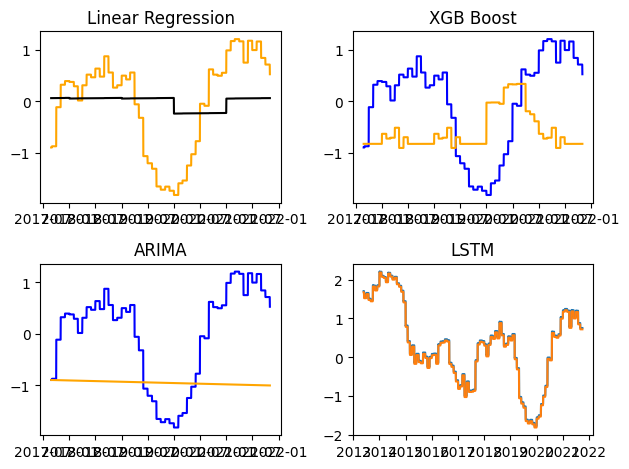

In [57]:
# Create a figure and subplots
fig , axes = plt.subplots(2 , 2)

# subplot in the first row, first column
axes[0, 0].plot(df.index[cut_off:], Y_test_lr, color='orange', label='X_test')
axes[0, 0].plot(df.index[cut_off:], Y_pred_lr, color='black', label='Prediction') 
# subplot in the first row, second column
axes[0, 1].plot(df.index[cut_off:] , Y_test_xgb , color='blue', label='X_test')
axes[0, 1].plot(df.index[cut_off:] , Y_pred_xgb , color='orange', label='Prediction')
# subplot in the second row, first column
axes[1, 0].plot(df.index[cut_off:] , Y_test_arima , color='blue', label='X_test')
axes[1, 0].plot(df.index[cut_off:] , Y_pred_arima , color='orange', label='Prediction')
# subplot in the second row, second column
axes[1, 1].plot(test_results['Test Predictions'])
axes[1, 1].plot(test_results['Actuals'])

# You can add titles to each subplot if desired
axes[0, 0].set_title('Linear Regression')
axes[0, 1].set_title('XGB Boost')
axes[1, 0].set_title('ARIMA')
axes[1, 1].set_title('LSTM')

# Adjust the layout to avoid overlapping subplots
plt.tight_layout()

# Show the figure
plt.show()

In [58]:
res.head()

,Actuals,LSTM Predictions,ARIMA Predictions,XGB Predictions,LR Predictions
Date,,,,,
2017-08-26,-0.894919,-0.862379,-0.894989,-0.824185,0.064427
2017-08-27,-0.894919,-0.862378,-0.895058,-0.824185,0.064438
2017-08-28,-0.894919,-0.862377,-0.895128,-0.824185,0.064449
2017-08-29,-0.894919,-0.862376,-0.895197,-0.824185,0.064461
2017-08-30,-0.894919,-0.862376,-0.895267,-0.824185,0.064472


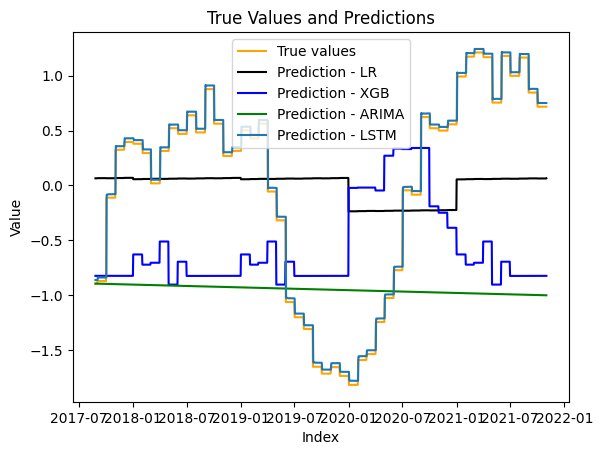

In [59]:
# Create a figure and a single subplot
fig, ax = plt.subplots()

# Plot the true values and the predictions from each model
ax.plot(res.index , res["Actuals"] , color='orange', label='True values')
ax.plot(res.index , res["LR Predictions"] , color='black', label='Prediction - LR')
ax.plot(res.index , res["XGB Predictions"] , color='blue', label='Prediction - XGB')
ax.plot(res.index , res["ARIMA Predictions"] , color='green', label='Prediction - ARIMA')
ax.plot(res.index , res["LSTM Predictions"] , label='Prediction - LSTM')

# Set the title and labels for the plot
ax.set_title('True Values and Predictions')
ax.set_xlabel('Index')
ax.set_ylabel('Value')

# Add a legend
ax.legend()

# Show the plot
plt.show()

In [60]:
temp = scaler.inverse_transform(df["Value"].values.reshape(-1 , 1))

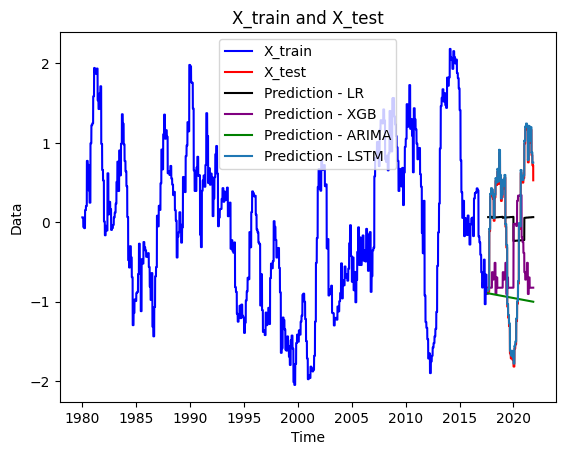

In [61]:
plt.plot(df.index[:cut_off] , temp[:cut_off] , color='blue', label='X_train')
plt.plot(df.index[cut_off:] , temp[cut_off:] , color='red', label='X_test')
#plt.plot(res.index , res["Actuals"] , color='orange', label='True values')
plt.plot(res.index , res["LR Predictions"] , color='black', label='Prediction - LR')
plt.plot(res.index , res["XGB Predictions"] , color='purple', label='Prediction - XGB')
plt.plot(res.index , res["ARIMA Predictions"] , color='green', label='Prediction - ARIMA')
plt.plot(res.index , res["LSTM Predictions"] , label='Prediction - LSTM')
plt.xlabel('Time')
plt.ylabel('Data')
plt.title('X_train and X_test')
plt.legend()
plt.show()

# **Resources**

**Any improvements are highly appreciated.**

In [62]:
#https://www.kaggle.com/code/abdallahwagih/gold-price-forecasting
#https://www.youtube.com/watch?v=c0k-YLQGKjY